<a href="https://colab.research.google.com/github/shauryasachdev/Vizuara_CV/blob/main/Overfitting_Prevention_Deep_NN_for_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
# ────────────────────────────────────────────────────────────────
# Standard library & OS / file handling
import os
import pathlib
import random
import glob

# Image & display utilities
from PIL import Image
import IPython.display as display
import matplotlib.pyplot as plt   # usually preferred over pylab

# Data science & numerics
import numpy as np

# Weights & Biases ────────────────────────────────────────────────
import wandb
from wandb.integration.keras import WandbMetricsLogger   # batch-level logging

# TensorFlow / Keras ──────────────────────────────────────────────
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
    Softmax,
    Input
)
import tensorflow_hub as hub

In [78]:
sweep_config = {

    'method' : 'grid',
    'metric' : {
        'name': 'valid_accuray',
        'goal': 'maximize'
              },

    'parameters': {
        'batch_size': {'values': [8]},
        'learning_rate': {'values': [0.0001]},
    'hidden_nodes' : {'values' : [128]},
    'img_size' : {'values' : [16]},
     'epochs' :{'values' : [10]}
                  }

    }

sweep_id = wandb.sweep(sweep_config, project="5-flowers-overfitting")

Create sweep with ID: xeaircns
Sweep URL: https://wandb.ai/shauryasachdev/5-flowers-overfitting/sweeps/xeaircns


In [79]:
from google.colab import drive
drive.mount('/content/drive')  # Mounts Drive at /content/drive/

# Set your desired Drive path (creates folder if it doesn't exist)
drive_path = '/content/drive/MyDrive/Colab Notebooks/flower_dataset/'

# Download and extract directly to the Drive path
# archive = tf.keras.utils.get_file(
#    'flower_photos.tgz',
#    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
#    cache_dir=drive_path,  # Saves here instead of local cache
#    extract=True
#)

# Your exact path as Path object
data_dir = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos')

# Verify
image_count = len(list(data_dir.glob('*/*.jpg')))
print("There are", image_count, "images.")  # Should be 3670

CLASS_NAMES = np.array(
    [item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt" and item.is_dir()]
)
print("These are the available classes:", CLASS_NAMES)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
There are 3670 images.
These are the available classes: ['dandelion' 'daisy' 'tulips' 'roses' 'sunflowers']


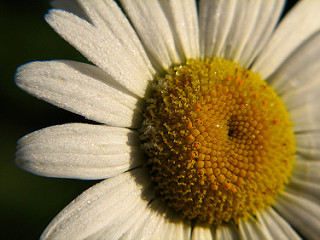

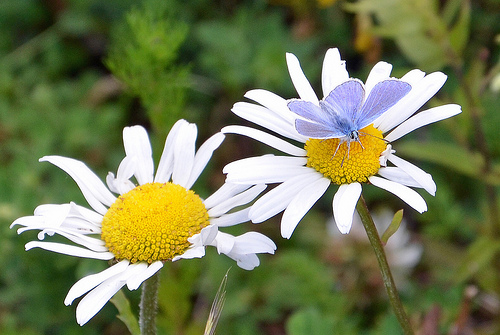

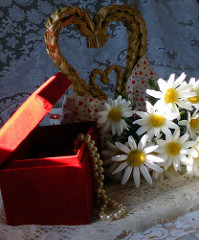

In [80]:
roses = list(data_dir.glob('daisy/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

In [81]:
# Your Drive path to the flower_photos folder with class subdirs
data_dir = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos')

# Collect all image paths and labels from Drive (local paths)
all_images = []
for class_name in CLASS_NAMES:
    class_dir = data_dir / class_name
    images = glob.glob(str(class_dir / '*.jpg'))
    for img in images:
        all_images.append(f"{img},{class_name}")

# Shuffle and split into train/eval (80/20)
random.shuffle(all_images)
num_total = len(all_images)
num_train = int(0.8 * num_total)
train_lines = all_images[:num_train]
eval_lines = all_images[num_train:]

# Write CSVs to Drive (using data_dir as base)
train_csv_path = os.path.join(str(data_dir), 'train_set.csv')
eval_csv_path = os.path.join(str(data_dir), 'eval_set.csv')

with open(train_csv_path, 'w') as f:
    f.write('\n'.join(train_lines))
with open(eval_csv_path, 'w') as f:
    f.write('\n'.join(eval_lines))

# Verify: Print first 5 lines of train CSV using shell (with quoted path to avoid syntax errors)
!head -5 "{train_csv_path}"

/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos/dandelion/2535727910_769c020c0d_n.jpg,dandelion
/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos/dandelion/14019781123_ea0f8722d4_n.jpg,dandelion
/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos/daisy/2077865117_9ed85191ae_n.jpg,daisy
/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos/dandelion/5862288632_1df5eb6dd0.jpg,dandelion
/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos/daisy/4540555191_3254dc4608_n.jpg,daisy


In [82]:
def train():
  with wandb.init() as run:
    config = wandb.config

    Img_Height = config.img_size
    Img_Width = config.img_size
    Img_Channels = 3


    def read_and_decode(filename, resize_dims):
      # Read the raw file
      img_bytes = tf.io.read_file(filename)
      # Decode the image data
      img = tf.image.decode_jpeg(img_bytes, channels=Img_Channels)
      # Convert the pixel values to float in [0,1]
      img = tf.image.convert_image_dtype(img, tf.float32)
      # Resize the image to desired dimensions
      img = tf.image.resize(img, resize_dims)
      return img

    def parse_csvline(csv_line):
      # record_defaults specify the data types for each column
      record_default = ["", ""]
      filename, label_string = tf.io.decode_csv(csv_line, record_default)

      # Load the image
      img = read_and_decode(filename, [Img_Height, Img_Width])

      # Conver label string to integer based on the Class_Names index
      label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
      return img, label

    train_dataset = (
      tf.data.TextLineDataset(train_csv_path)
      .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(config.batch_size)
      .prefetch(tf.data.AUTOTUNE)
      )

    eval_dataset = (
      tf.data.TextLineDataset(eval_csv_path)
      .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(config.batch_size)
      .prefetch(tf.data.AUTOTUNE)
      )

    regularizer = tf.keras.regularizers.l1_l2(0,0.01)

    model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=(Img_Height, Img_Width, Img_Channels)),

      tf.keras.layers.Dense(config.hidden_nodes, kernel_regularizer=regularizer),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.Dropout(0.5),

      tf.keras.layers.Dense(len(CLASS_NAMES), kernel_regularizer=regularizer),
      tf.keras.layers.BatchNormalization(), # Instantiated the layer here
      tf.keras.layers.Activation('softmax'),
    ])

    model.compile(
      optimizer =tf.keras.optimizers.Adam(config.learning_rate),
      loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
      metrics=["accuracy"]
    )

    callbacks = [
      WandbMetricsLogger(log_freq=5),
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,
                                       restore_best_weights=True)
    ]

    model.fit(
      train_dataset,
      validation_data = eval_dataset,
      epochs = config.epochs,
      callbacks = callbacks
  )

In [83]:
wandb.agent(sweep_id, function=train)

wandb: Agent Starting Run: olqhdngx with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	hidden_nodes: 128
wandb: 	img_size: 16
wandb: 	learning_rate: 0.0001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


    367/Unknown 20s 49ms/step - accuracy: 0.2231 - loss: 4.1685

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


367/367 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.2232 - loss: 4.1681 - val_accuracy: 0.3433 - val_loss: 3.6366
Epoch 2/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.3259 - loss: 3.6660 - val_accuracy: 0.3965 - val_loss: 3.3683
Epoch 3/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.3830 - loss: 3.4279 - val_accuracy: 0.4360 - val_loss: 3.1968
Epoch 4/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.4237 - loss: 3.1986 - val_accuracy: 0.4578 - val_loss: 3.0303
Epoch 5/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.4347 - loss: 3.0124 - val_accuracy: 0.4646 - val_loss: 2.8578
Epoch 6/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.4555 - loss: 2.8435 - val_accuracy: 0.4905 - val_loss: 2.7207
Epoch 7/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.4858 - loss: 2.6843 - val_accuracy: 0.4659 - val_loss: 2.6097
Epoch 8/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.4933 - loss: 2.5391 - val_accurac

batch/accuracy,▁▁▁▂▂▄▄▄▄▅▅▅▅▆▅▆▆▆▆▆▆▆▆▅▆▆▆▆▇▇▇▇▇▇▇█████
batch/batch_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,███▇▇▆▆▆▆▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▃▄▅▅▆▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▃▃▂▁▁
epoch/val_accuracy,▁▄▅▆▇█▇▇▇▇
epoch/val_loss,█▇▆▅▄▃▂▂▁▁
batch/accuracy,0.53415


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
 import math

for images, labels in eval_dataset.take(1):
  batch_predictions = model.predict(images)
  predicted_indices = np.argmax(batch_predictions, axis = 1)

  num_images = images.shape[0]
  num_cols = 4
  num_rows = math.ceil(num_images / num_cols)

  plt.figure(figsize=(12,3*num_rows))

  for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(images[i].numpy())
    plt.axis("off")

    pred_class = CLASS_NAMES[predicted_indices[i]]
    actual_class = CLASS_NAMES[labels[i].numpy()]

    plt.title(f"Predicted: {pred_class}\nActual: {actual_class}", fontsize = 10)

  plt.tight_layout()
  plt.show